In [1]:
import sys
!pip install pandas
import pandas as pd
import numpy as np
import nltk


import re
import nltk
from joblib import dump, load
import matplotlib.pyplot as plt
pd.options.display.max_colwidth=200
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  # Asegúrate de importar StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score




import scipy.stats as stats
import seaborn as sns; sns.set()  # for plot styling

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3D plots
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_error as mae


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree


from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold

# Metricas
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# q-q plots
import scipy.stats as stats


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install LightFM
from lightfm import LightFM
from lightfm.data import Dataset


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## Carga de datos

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#pd2 = pd.read_csv('/content/drive/MyDrive/Corona/b2c_nuevo.csv' , sep=",", encoding="utf-8")
pd2 = pd.read_csv('./b2c_nuevo.csv' , sep=",", encoding="utf-8")

In [5]:

b2c = pd2.copy()

## Implementación B2C

In [6]:
b2c.columns

Index(['edad_promedio', 'ingreso_laboral_promedio', 'porcentaje_urbano',
       'IPUG', 'GINI', 'num_pedidos', 'categorias_diferentes',
       'Total de edificaciones en obra', 'pedido', 'id', 'edad', 'municipio',
       'asesor', 'punto de venta', 'cluster', 'categoria_macro', 'categoria',
       'subcategoria', 'producto', 'color', 'cantidad', 'precio', 'valor',
       'alineación con portafolio estratégico', 'log_cantidad', 'log_precio',
       'log_valor', 'ajustada_alineacion', 'total_productos', 'total_gasto',
       'precio_promedio', 'ticket_promedio', 'cantidad_promedio',
       'zona_AMAZONAS', 'zona_ANTIOQUIA', 'zona_ARAUCA', 'zona_ATLÁNTICO',
       'zona_BOGOTÁ', 'zona_BOLÍVAR', 'zona_BOYACA', 'zona_CALDAS',
       'zona_CAQUETA', 'zona_CASANARE', 'zona_CAUCA', 'zona_CESAR',
       'zona_CHOCO', 'zona_CUNDINAMARCA', 'zona_CÓRDOBA', 'zona_GUAINIA',
       'zona_GUAVIARE', 'zona_HUILA', 'zona_LA GUAJIRA', 'zona_MAGDALENA',
       'zona_META', 'zona_NARIÑO', 'zona_NORTE SANTA

In [7]:
b2c = b2c.dropna(subset=['id', 'producto'])


In [8]:
print(b2c['id'][:])

0               2
1               3
2               3
3               3
4               3
            ...  
2553800    368060
2553801     78489
2553802    415279
2553803    419226
2553804    419226
Name: id, Length: 2553805, dtype: int64


## Pipeline LightFM

In [9]:
# from lightfm.data import Dataset

# dataset = Dataset()

# # USER features
# user_features = (
#     [f"cluster:{x}" for x in b2c['cluster'].astype(str).unique()] +
#     [f"municipio:{x}" for x in b2c['municipio'].astype(str).unique()] +
#     [f"asesor:{x}" for x in b2c['asesor'].astype(str).unique()] +
#     [f"punto:{x}" for x in b2c['punto de venta'].astype(str).unique()] +
#     b2c.columns[b2c.columns.str.startswith("zona_")].tolist()
# )

# # ITEM features
# item_features = (
#     [f"categoria_macro:{x}" for x in b2c['categoria_macro'].astype(str).unique()] +
#     [f"subcategoria:{x}" for x in b2c['subcategoria'].astype(str).unique()] +
#     [f"color:{x}" for x in b2c['color'].astype(str).unique()]
# )

# dataset.fit(
#     users=b2c['id'].unique(),
#     items=b2c['producto'].unique(),
#     user_features=user_features,
#     item_features=item_features
# )


In [10]:

# interactions, _ = dataset.build_interactions([
#     (row['id'], row['producto']) for _, row in b2c.iterrows()
# ])


Ahora establecemos como se realiza la caracterización de los clientes y de los porductos

In [11]:
# def construir_features_usuario(df):
#     features = []
#     for _, row in df.iterrows():
#         f = [
#             f"cluster:{row['cluster']}",
#             f"municipio:{row['municipio']}",
#             f"asesor:{row['asesor']}",
#             f"punto:{row['punto de venta']}"
#         ]
#         for zona in df.columns[df.columns.str.startswith("zona_")]:
#             if row[zona] == 1:
#                 f.append(zona)
#         features.append((row['id'], f))
#     return features


# def construir_features_producto(df):
#     features = []
#     for _, row in df.iterrows():
#         f = [
#             f"categoria_macro:{row['categoria_macro']}",
#             f"subcategoria:{row['subcategoria']}",
#             f"color:{row['color']}"
#         ]
#         features.append((row['producto'], f))
#     return features


# user_features = dataset.build_user_features(construir_features_usuario(b2c))
# item_features = dataset.build_item_features(construir_features_producto(b2c))


In [12]:
# model = LightFM(loss='warp-kos', no_components=16)
# model.fit(interactions, user_features=user_features, item_features=item_features, epochs=15, num_threads=2)


In [13]:
# b2c['id'].dropna().unique()[:10]


In [14]:
# usuario_interno = dataset.mapping()[0][11]
# scores = model.predict(usuario_interno, np.arange(len(dataset.mapping()[2])), user_features=user_features, item_features=item_features)
# # Normalizar scores entre 0 y 1
# min_score = scores.min()
# max_score = scores.max()

# # Evitar división por cero
# if max_score > min_score:
#     scores_normalizados = (scores - min_score) / (max_score - min_score)
# else:
#     scores_normalizados = np.zeros_like(scores)

# top_items = np.argsort(-scores)[:10]
# productos = list(dataset.mapping()[2].keys())
# print("Recomendaciones:", [productos[i] for i in top_items])


In [15]:
# from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

# # Calcular métricas usando el conjunto completo de interacciones
# precision_lfm = precision_at_k(model, interactions, user_features=user_features, item_features=item_features, k=5).mean()
# recall_lfm = recall_at_k(model, interactions, user_features=user_features, item_features=item_features, k=5).mean()
# auc_lfm = auc_score(model, interactions, user_features=user_features, item_features=item_features).mean()

# # Crear diccionario con métricas
# metricas_lfm_b2c = {
#     "Precision": round(precision_lfm, 4),
#     "Recall": round(recall_lfm, 4),
#     "AUC": round(auc_lfm, 4)
# }

# # Mostrar resultados
# print("Métricas LightFM B2C:")
# for k, v in metricas_lfm_b2c.items():
#     print(f"- {k}: {v}")


In [16]:
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
import pandas as pd
import numpy as np

# -------------------------
# PREPARAR DATOS
# -------------------------

top_municipios = b2c['municipio'].value_counts().nlargest(50).index
b2c['municipio'] = b2c['municipio'].where(b2c['municipio'].isin(top_municipios), 'otros')

top_asesores = b2c['asesor'].value_counts().nlargest(50).index
b2c['asesor'] = b2c['asesor'].where(b2c['asesor'].isin(top_asesores), 'otros')

top_puntos = b2c['punto de venta'].value_counts().nlargest(50).index
b2c['punto de venta'] = b2c['punto de venta'].where(b2c['punto de venta'].isin(top_puntos), 'otros')

# Inicializar dataset
dataset = Dataset()

# USER features
user_features_list = (
    [f"cluster:{x}" for x in b2c['cluster'].astype(str).unique()] +
    [f"municipio:{x}" for x in b2c['municipio'].astype(str).unique()] +
    [f"asesor:{x}" for x in b2c['asesor'].astype(str).unique()] +
    [f"punto:{x}" for x in b2c['punto de venta'].astype(str).unique()] +
    b2c.columns[b2c.columns.str.startswith("zona_")].tolist()
)

# ITEM features
item_features_list = (
    [f"categoria_macro:{x}" for x in b2c['categoria_macro'].astype(str).unique()] +
    [f"subcategoria:{x}" for x in b2c['subcategoria'].astype(str).unique()] +
    [f"color:{x}" for x in b2c['color'].astype(str).unique()]
)

# Fit mappings
dataset.fit(
    users=b2c['id'].unique(),
    items=b2c['producto'].unique(),
    user_features=user_features_list,
    item_features=item_features_list
)

# Interacciones implícitas (puedes usar .value o .cantidad como peso si quieres ponderar)
interactions, _ = dataset.build_interactions([
    (row['id'], row['producto']) for _, row in b2c.iterrows()
])


In [17]:

# -------------------------
# CONSTRUIR FEATURES
# -------------------------

def construir_features_usuario(df):
    features = []
    for _, row in df.iterrows():
        f = [
            f"cluster:{row['cluster']}",
            f"municipio:{row['municipio']}",
            f"asesor:{row['asesor']}",
            f"punto:{row['punto de venta']}"
        ]
        for zona in df.columns[df.columns.str.startswith("zona_")]:
            if row[zona] == 1:
                f.append(zona)
        features.append((row['id'], f))
    return features

def construir_features_producto(df):
    features = []
    for _, row in df.iterrows():
        f = [
            f"categoria_macro:{row['categoria_macro']}",
            f"subcategoria:{row['subcategoria']}",
            f"color:{row['color']}"
        ]
        features.append((row['producto'], f))
    return features

user_features = dataset.build_user_features(construir_features_usuario(b2c))
item_features = dataset.build_item_features(construir_features_producto(b2c))



In [18]:
# -------------------------
# ENTRENAMIENTO Y EVALUACIÓN
# -------------------------

# Quitar duplicados de (id, producto) antes de construir interacciones
b2c_interacciones = b2c[['id', 'producto']].drop_duplicates()

interactions, _ = dataset.build_interactions([
    (row['id'], row['producto']) for _, row in b2c_interacciones.iterrows()
])

# Dividir en train y test
train, test = random_train_test_split(interactions, test_percentage=0.2, random_state=42)

# Entrenar modelo
model = LightFM(loss='warp-kos', no_components=16, random_state=20)
model.fit(train, user_features=user_features, item_features=item_features, epochs=15, num_threads=4)




In [19]:
# Evaluar
precision = precision_at_k(
    model, test, train_interactions=train,
    user_features=user_features, item_features=item_features, k=10
).mean()

recall = recall_at_k(
    model, test, train_interactions=train,
    user_features=user_features, item_features=item_features, k=10
).mean()

auc = auc_score(
    model, test, train_interactions=train,
    user_features=user_features, item_features=item_features
).mean()

metricas_lfm_b2c = {
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "AUC": round(auc, 4)
}

# Mostrar resultados
print("Métricas LightFM B2C:")
for k, v in metricas_lfm_b2c.items():
    print(f"- {k}: {v}")

Métricas LightFM B2C:
- Precision: 0.011900000274181366
- Recall: 0.0657
- AUC: 0.9365000128746033


## Guardar el modelo

In [20]:
# Define the path to save the model
model_path = './modelos/lightfm_model_b2c.pkl'

# Save the trained LightFM model
dump(model, model_path)

print(f"Model saved successfully to {model_path}")

# Optional: Save the dataset object and mappings as well if needed for loading
dataset_path = './modelos/lightfm_dataset_b2c.pkl'
dump(dataset, dataset_path)
print(f"Dataset saved successfully to {dataset_path}")

Model saved successfully to ./modelos/lightfm_model_b2c.pkl
Dataset saved successfully to ./modelos/lightfm_dataset_b2c.pkl


## Modelo Tabular

In [21]:
positivos = b2c[['id', 'producto']].drop_duplicates().copy()
positivos['interaccion'] = 1


In [22]:
from tqdm import tqdm  # barra de progreso

usuarios = b2c['id'].unique()
productos = b2c['producto'].unique()
compras = b2c.groupby('id')['producto'].apply(set).to_dict()

negativos = []
rng = np.random.default_rng(seed=42)

# Número de negativos por usuario
k_negativos = 5

for u in tqdm(usuarios):
    comprados = compras.get(u, set())
    candidatos = list(set(productos) - comprados)

    if len(candidatos) == 0:
        continue  # este usuario ya compró todo

    muestra = rng.choice(candidatos, size=min(k_negativos, len(candidatos)), replace=False)
    negativos.extend([(u, p, 0) for p in muestra])

# Convertir a DataFrame
negativos = pd.DataFrame(negativos, columns=['id', 'producto', 'interaccion'])

# Positivos
positivos = b2c[['id', 'producto']].drop_duplicates().copy()
positivos['interaccion'] = 1

# Unir todo
df_tabular = pd.concat([positivos, negativos], axis=0, ignore_index=True)


100%|██████████| 419221/419221 [10:00<00:00, 698.32it/s]


In [23]:
features_usuario = b2c.drop_duplicates('id').set_index('id')[
    ['edad', 'edad_promedio',
       'ingreso_laboral_promedio', 'GINI', 'IPUG',
       'cluster']
]

features_producto = b2c.drop_duplicates('producto').set_index('producto')[
    ['categoria_macro', 'subcategoria', 'color', 'precio', 'alineación con portafolio estratégico']
]

df_tabular = df_tabular.merge(features_usuario, on='id', how='left')
df_tabular = df_tabular.merge(features_producto, on='producto', how='left')


In [24]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

# --- 1. Selección de columnas útiles (excluye id, producto, interaccion) ---
X = df_tabular.drop(columns=['id', 'producto', 'interaccion'])
y = df_tabular['interaccion']

# --- 2. Tratar nulos y reducir cardinalidad ---
X.fillna("desconocido", inplace=True)

# Reducir cardinalidad de 'color' si tiene muchos valores
if X['color'].nunique() > 20:
    top_colores = X['color'].value_counts().nlargest(20).index
    X['color'] = X['color'].where(X['color'].isin(top_colores), 'otros')

# --- 3. Convertir categóricas a tipo 'category' ---
categoricas = ['cluster', 'categoria_macro', 'subcategoria', 'color']
for col in categoricas:
    X[col] = X[col].astype('category')

# --- 4. Split y entrenamiento ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

modelo_xgb = XGBClassifier(
    tree_method='hist',
    enable_categorical=True,
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

modelo_xgb.fit(X_train, y_train)

# --- 5. Evaluación ---
probs = modelo_xgb.predict_proba(X_test)[:, 1]
preds = modelo_xgb.predict(X_test)

print("AUC:", round(roc_auc_score(y_test, probs), 4))
print(classification_report(y_test, preds))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:39:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUC: 0.9146
              precision    recall  f1-score   support

           0       0.84      0.86      0.85    419221
           1       0.83      0.81      0.82    356427

    accuracy                           0.84    775648
   macro avg       0.84      0.83      0.84    775648
weighted avg       0.84      0.84      0.84    775648



## Guardar el modelo tabular

In [72]:
# Define the path to save the XGBoost model
model_xgb_path = './modelos/xgb_model_b2c.pkl'

# Save the trained XGBoost model
dump(modelo_xgb, model_xgb_path)

print(f"XGBoost model saved successfully to {model_xgb_path}")

# Guardar features para uso en el recomendador
dump(features_usuario.reset_index(), './modelos/b2c_user_features_df.pkl')
dump(features_producto.reset_index(), './modelos/b2c_item_features_df.pkl')

print("✅ Features de usuario y producto guardados exitosamente.")


XGBoost model saved successfully to ./modelos/xgb_model_b2c.pkl
✅ Features de usuario y producto guardados exitosamente.


In [ ]:
import pandas as pd
from joblib import dump

# Cargar base B2C
b2c = pd.read_csv('./b2c_nuevo.csv')

# --- USER FEATURES ---
user_columns = ['id', 'zona', 'cluster']
xgb_user_feats = b2c[user_columns].drop_duplicates(subset='id').set_index('id')
xgb_user_feats = xgb_user_feats.reset_index()

# --- ITEM FEATURES ---
item_columns = ['producto', 'categoria_macro', 'subcategoria', 'color']
xgb_item_feats = b2c[item_columns].drop_duplicates(subset='producto').set_index('producto')
xgb_item_feats = xgb_item_feats.reset_index()

# Guardar como .pkl
dump(xgb_user_feats, './modelos/b2c_user_features_df.pkl')
dump(xgb_item_feats, './modelos/b2c_item_features_df.pkl')

print("✅ Archivos guardados: b2c_user_features_df.pkl y b2c_item_features_df.pkl")


## Comparación XGBoost sin datos enriquecidos

In [26]:
# sin GINI e IPUG ---
features_usuario_sin_enriquecer = b2c.drop_duplicates('id').set_index('id')[[
    'edad', 'edad_promedio', 'ingreso_laboral_promedio', 'cluster'
]]

features_producto = b2c.drop_duplicates('producto').set_index('producto')[[
    'categoria_macro', 'subcategoria', 'color', 'precio', 'alineación con portafolio estratégico'
]]


df_tabular_simple = df_tabular[['id', 'producto', 'interaccion']].copy()  # columnas clave
df_tabular_simple = df_tabular_simple.merge(features_usuario_sin_enriquecer, on='id', how='left')
df_tabular_simple = df_tabular_simple.merge(features_producto, on='producto', how='left')

# Preparación
X_simple = df_tabular_simple.drop(columns=['id', 'producto', 'interaccion'])
y_simple = df_tabular_simple['interaccion']
X_simple.fillna("desconocido", inplace=True)

# Reducción cardinalidad
if X_simple['color'].nunique() > 20:
    top_colores = X_simple['color'].value_counts().nlargest(20).index
    X_simple['color'] = X_simple['color'].where(X_simple['color'].isin(top_colores), 'otros')

for col in ['cluster', 'categoria_macro', 'subcategoria', 'color']:
    X_simple[col] = X_simple[col].astype('category')

#Train-test split y entrenamiento
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_simple, y_simple, stratify=y_simple, test_size=0.2, random_state=42
)

modelo_xgb_simple = XGBClassifier(
    tree_method='hist',
    enable_categorical=True,
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

modelo_xgb_simple.fit(X_train_s, y_train_s)

# --- 8. Evaluación del modelo SIN enriquecer ---
probs_s = modelo_xgb_simple.predict_proba(X_test_s)[:, 1]
preds_s = modelo_xgb_simple.predict(X_test_s)

metricas_xgb_sin_enriquecer = {
    "Accuracy": round(accuracy_score(y_test_s, preds_s), 4),
    "Precision": round(precision_score(y_test_s, preds_s), 4),
    "Recall": round(recall_score(y_test_s, preds_s), 4),
    "F1-score": round(f1_score(y_test_s, preds_s), 4),
    "AUC": round(roc_auc_score(y_test_s, probs_s), 4)
}

print("Métricas del modelo SIN GINI e IPUG:")
for k, v in metricas_xgb_sin_enriquecer.items():
    print(f"- {k}: {v}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:39:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Métricas del modelo SIN GINI e IPUG:
- Accuracy: 0.8359
- Precision: 0.8308
- Recall: 0.8074
- F1-score: 0.8189
- AUC: 0.9135


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- Diccionario de métricas del modelo XGBoost B2C ---
metricas_xgb_b2c = {
    "Accuracy": round(accuracy_score(y_test, preds), 4),
    "Precision": round(precision_score(y_test, preds), 4),
    "Recall": round(recall_score(y_test, preds), 4),
    "F1-score": round(f1_score(y_test, preds), 4),
    "AUC": round(roc_auc_score(y_test, probs), 4)
}




<Figure size 1000x600 with 0 Axes>

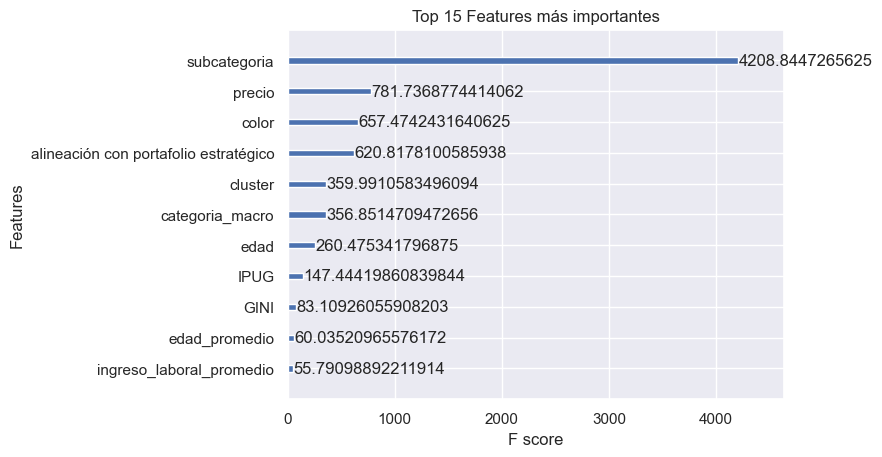

In [28]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(modelo_xgb, max_num_features=15, importance_type='gain')
plt.title("Top 15 Features más importantes")
plt.show()


In [29]:
def recomendar_con_xgboost(cliente_id, top_n=10):
    # Productos ya comprados por el cliente
    productos_comprados = set(b2c[b2c['id'] == cliente_id]['producto'].unique())

    # Productos candidatos (no comprados)
    todos_productos = b2c['producto'].unique()
    productos_candidatos = list(set(todos_productos) - productos_comprados)

    if not productos_candidatos:
        return f"Cliente {cliente_id} ya ha comprado todos los productos."

    # Crear dataset de predicción
    df_pred = pd.DataFrame({'id': cliente_id, 'producto': productos_candidatos})

    # Merge con features del usuario
    df_pred = df_pred.merge(features_usuario, on='id', how='left')

    # Merge con features del producto
    df_pred = df_pred.merge(features_producto, on='producto', how='left')

    # Tratar nulos
    df_pred.fillna("desconocido", inplace=True)

    # Reducir cardinalidad de color si es necesario
    if 'color' in df_pred.columns and df_pred['color'].nunique() > 20:
        top_colores = features_producto['color'].value_counts().nlargest(20).index
        df_pred['color'] = df_pred['color'].where(df_pred['color'].isin(top_colores), 'otros')

    # Convertir variables categóricas
    for col in ['cluster', 'categoria_macro', 'subcategoria', 'color']:
        if col in df_pred.columns:
            df_pred[col] = df_pred[col].astype('category')

    # Eliminar columnas no usadas durante el entrenamiento
    X_pred = df_pred.drop(columns=['id', 'producto'])

    # Predecir probabilidad de compra
    probs = modelo_xgb.predict_proba(X_pred)[:, 1]

    # Construir ranking
    df_pred['score'] = probs
    top_recomendaciones = df_pred.sort_values('score', ascending=False).head(top_n)

    return top_recomendaciones[['producto', 'score']]


In [30]:
recomendar_con_xgboost(cliente_id=11, top_n=10)


,producto,score
7238,producto_19,0.986930
4960,producto_49,0.984224
7121,producto_72,0.982433
787,producto_28,0.979594
6713,producto_27,0.976954
4104,producto_3,0.976453
5308,producto_112,0.973738
5568,producto_143,0.971046
1876,producto_40,0.971046
2216,producto_119,0.969817


## Recomendador HIBRIDO

In [36]:
pd_precios = pd.read_csv('./df_precios.csv' , sep=",", encoding="utf-8")
precios = pd_precios.copy()

In [37]:
def recomendar_hibrido(cliente_id, top_n=10, alpha=0.5):
    # Validar que cliente exista en el mapping de LightFM
    if cliente_id not in dataset.mapping()[0]:
        return f"Cliente {cliente_id} no está en el dataset de LightFM."

    # Productos ya comprados
    productos_comprados = set(b2c[b2c['id'] == cliente_id]['producto'].unique())
    productos_totales = b2c['producto'].unique()
    productos_candidatos = list(set(productos_totales) - productos_comprados)

    if not productos_candidatos:
        return f"Cliente {cliente_id} ya ha comprado todos los productos."

    # --- LightFM: obtener scores ---
    usuario_interno = dataset.mapping()[0][cliente_id]
    productos_idx = [dataset.mapping()[2][p] for p in productos_candidatos if p in dataset.mapping()[2]]
    scores_lfm = model.predict(usuario_interno, productos_idx, user_features=user_features, item_features=item_features)

    # Mapear scores a productos
    lfm_scores = pd.DataFrame({'producto': [p for p in productos_candidatos if p in dataset.mapping()[2]],
                               'score_lfm': scores_lfm})

    # --- XGBoost: obtener scores ---
    df_pred = pd.DataFrame({'id': cliente_id, 'producto': lfm_scores['producto']})
    df_pred = df_pred.merge(features_usuario, on='id', how='left')
    df_pred = df_pred.merge(features_producto, on='producto', how='left')
    df_pred.fillna("desconocido", inplace=True)

    if 'color' in df_pred.columns and df_pred['color'].nunique() > 20:
        top_colores = features_producto['color'].value_counts().nlargest(20).index
        df_pred['color'] = df_pred['color'].where(df_pred['color'].isin(top_colores), 'otros')

    for col in ['cluster', 'categoria_macro', 'subcategoria', 'color']:
        if col in df_pred.columns:
            df_pred[col] = df_pred[col].astype('category')

    X_pred = df_pred.drop(columns=['id', 'producto'])
    scores_xgb = modelo_xgb.predict_proba(X_pred)[:, 1]

    # Combinar scores
    if lfm_scores['score_lfm'].nunique() > 1:
        min_lfm = lfm_scores['score_lfm'].min()
        max_lfm = lfm_scores['score_lfm'].max()
        lfm_scores['score_lfm_norm'] = (lfm_scores['score_lfm'] - min_lfm) / (max_lfm - min_lfm)
    else:
        lfm_scores['score_lfm_norm'] = 0.5  

    lfm_scores['score_xgb'] = scores_xgb
    lfm_scores['score_hibrido'] = alpha * lfm_scores['score_lfm_norm'] + (1 - alpha) * lfm_scores['score_xgb']

    # --- Alineación estratégica ---
    alineacion_dict = b2c.drop_duplicates('producto').set_index('producto')['alineación con portafolio estratégico'].to_dict()
    lfm_scores['alineación estratégica'] = lfm_scores['producto'].map(alineacion_dict)

    # --- Precio ---
    precios_dict = precios.set_index('producto')['precio'].to_dict()
    lfm_scores['precio'] = lfm_scores['producto'].map(precios_dict)
    lfm_scores = lfm_scores[lfm_scores['precio'].notna()]

    # --- Valor esperado ---
    lfm_scores['valor_esperado'] = lfm_scores['score_hibrido'] * lfm_scores['precio']

    # Ordenar y devolver top N
    top_recomendaciones = lfm_scores.sort_values('score_hibrido', ascending=False).head(top_n)

    return top_recomendaciones[['producto', 'score_lfm_norm', 'score_xgb', 'score_hibrido',
                                 'alineación estratégica', 'precio', 'valor_esperado']]


In [38]:
recomendar_hibrido(cliente_id=2, top_n=10, alpha=0.6)


,producto,score_lfm_norm,score_xgb,score_hibrido,alineación estratégica,precio,valor_esperado
784,producto_28,0.985625,0.974872,0.981324,0.038016,0.346619,0.340146
6702,producto_27,0.985631,0.972189,0.980254,0.041472,0.368714,0.361434
1617,producto_277,0.985637,0.950663,0.971647,0.200448,1.698571,1.650412
4947,producto_1227,0.974117,0.892908,0.941633,0.110592,0.441214,0.415462
3287,producto_101,0.985428,0.867990,0.938453,0.210816,1.640572,1.539599
2926,producto_115,0.985406,0.867990,0.938440,0.210816,1.657143,1.555129
467,producto_648,0.961773,0.874970,0.927052,0.411264,3.287357,3.047549
6583,producto_30,0.950757,0.862492,0.915451,0.186624,1.684762,1.542318
908,producto_609,0.938504,0.870861,0.911447,0.273024,3.219000,2.933946
6564,producto_258,0.960956,0.823758,0.906077,0.400896,4.747714,4.301794


## Comparación de Modelos

In [46]:
def comparar_modelos(cliente_id, top_n=30, alpha=0.5, normalizar_lfm=True):
    df_scores = recomendar_hibrido(cliente_id=cliente_id, top_n=top_n, alpha=alpha)

    if isinstance(df_scores, str):
        print(df_scores)
        return


    # --- Escalar LightFM si se requiere ---
    cols_plot = ['score_lfm_norm', 'score_xgb', 'score_hibrido']

    # --- Estadísticas ---
    print("Estadísticas de scores:")
    for col in cols_plot:
        print(f"\n{col}:")
        print(df_scores[col].describe())

    # --- Gráfica mejorada ---
    df_plot = df_scores.melt(id_vars='producto', value_vars=cols_plot,
                             var_name='modelo', value_name='score')

    plt.figure(figsize=(14, 6))
    sns.barplot(data=df_plot, x='producto', y='score', hue='modelo', palette='Set2')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Comparación de scores normalizados para Cliente {cliente_id}" if normalizar_lfm else f"Comparación de scores para Cliente {cliente_id}")
    plt.ylabel("Score")
    plt.xlabel("Producto")
    plt.legend(title='Modelo')
    plt.tight_layout()
    plt.show()

    # --- Ranking comparado ---
    df_scores['rank_lfm'] = df_scores['score_lfm_norm'].rank(ascending=False)
    df_scores['rank_xgb'] = df_scores['score_xgb'].rank(ascending=False)
    df_scores['rank_diff'] = df_scores['rank_xgb'] - df_scores['rank_lfm']
    print("\nTop 5 mayores diferencias de ranking (XGBoost vs LightFM):")
    print(df_scores[['producto', 'rank_lfm', 'rank_xgb', 'rank_diff']].sort_values('rank_diff', key=abs, ascending=False).head())


Estadísticas de scores:

score_lfm_norm:
count    15.000000
mean      0.966431
std       0.016282
min       0.938504
25%       0.958603
50%       0.961747
75%       0.985417
max       0.985637
Name: score_lfm_norm, dtype: float64

score_xgb:
count    15.000000
mean      0.867275
std       0.060339
min       0.784847
25%       0.822550
50%       0.867990
75%       0.883939
max       0.974872
Name: score_xgb, dtype: float64

score_hibrido:
count    15.000000
mean      0.926768
std       0.030955
min       0.890987
25%       0.903301
50%       0.915451
75%       0.940043
max       0.981324
Name: score_hibrido, dtype: float64


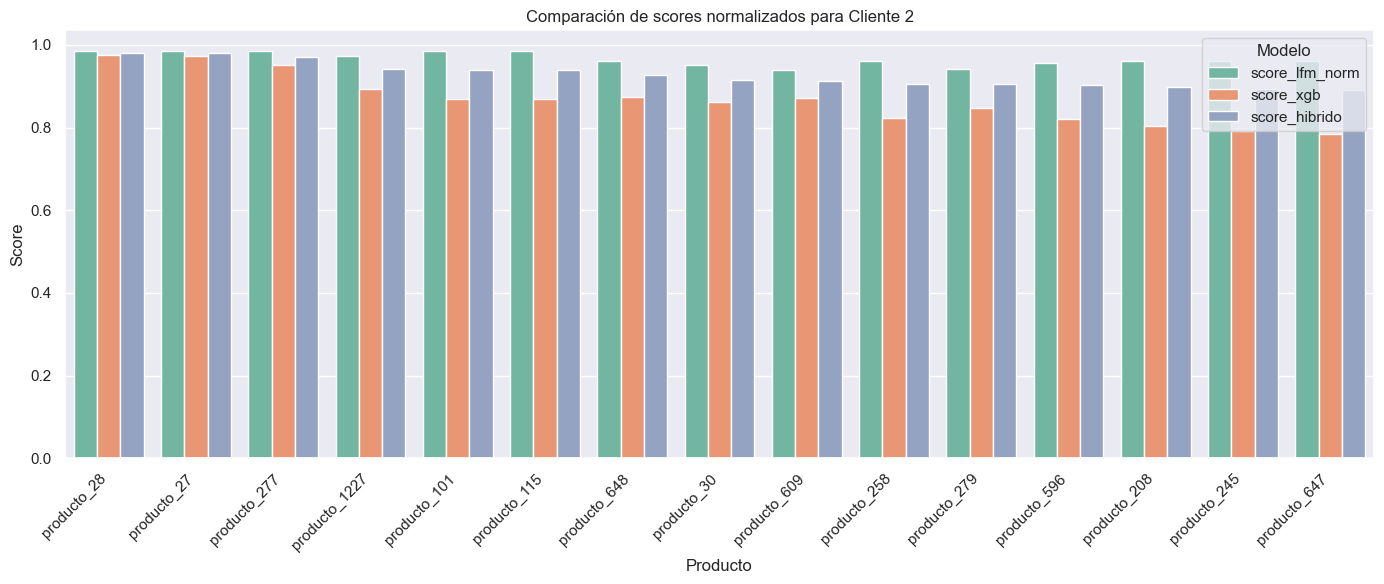


Top 5 mayores diferencias de ranking (XGBoost vs LightFM):
          producto  rank_lfm  rank_xgb  rank_diff
908   producto_609      15.0       6.0       -9.0
6026  producto_647       8.0      15.0        7.0
6583   producto_30      13.0       9.0       -4.0
4503  producto_279      14.0      10.0       -4.0
2274  producto_208       9.0      13.0        4.0


In [47]:
comparar_modelos(cliente_id=2, top_n=15, alpha=0.6)


In [48]:
import joblib
import os

 # Crear carpeta si no existe
os.makedirs("modelos", exist_ok=True)

# # Guardar modelos B2C
# joblib.dump(modelo_xgb, 'modelos/b2c_model_xgb.pkl')
# joblib.dump(model, 'modelos/b2c_model_lfm.pkl')
# joblib.dump(dataset, 'modelos/b2c_dataset.pkl')
joblib.dump(user_features, 'modelos/b2c_user_features.pkl')
joblib.dump(item_features, 'modelos/b2c_item_features.pkl')


# print("Modelos y objetos B2C guardados correctamente.")

['modelos/b2c_item_features.pkl']

In [49]:
# Obtener recomendaciones híbridas para un cliente B2C
df_hibrido_b2c = recomendar_hibrido(cliente_id=11, top_n=20, alpha=0.5)

# Validar si se obtuvo un DataFrame o un mensaje de error
if isinstance(df_hibrido_b2c, pd.DataFrame):
    # Crear diccionario con métricas estadísticas del modelo híbrido
    metricas_hibrido_b2c = {
        "Media score híbrido": round(df_hibrido_b2c["score_hibrido"].mean(), 4),
        "Máximo score híbrido": round(df_hibrido_b2c["score_hibrido"].max(), 4),
        "Mínimo score híbrido": round(df_hibrido_b2c["score_hibrido"].min(), 4),
        "Desviación estándar": round(df_hibrido_b2c["score_hibrido"].std(), 4)
    }

    print("Métricas del modelo híbrido B2C:")
    for k, v in metricas_hibrido_b2c.items():
        print(f"- {k}: {v}")
else:
    print(f"Error: {df_hibrido_b2c}")


Métricas del modelo híbrido B2C:
- Media score híbrido: 0.906000018119812
- Máximo score híbrido: 0.9807999730110168
- Mínimo score híbrido: 0.8748000264167786
- Desviación estándar: 0.03449999913573265


In [50]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt


In [51]:
# Librerías
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Inputs
id_input = widgets.Text(
    value='11',
    placeholder='ID del cliente',
    description='Cliente ID:',
    disabled=False
)

topn_slider = widgets.IntSlider(
    value=10,
    min=1,
    max=30,
    step=1,
    description='Top-N:',
    continuous_update=False
)

alpha_slider = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    step=0.05,
    description='Peso LFM (α):',
    continuous_update=False
)

btn = widgets.Button(description="Comparar Modelos")
output = widgets.Output()

# Lógica
def on_click(b):
    output.clear_output()
    with output:
        try:
            cliente_id = int(id_input.value)
            topn = topn_slider.value
            alpha = alpha_slider.value

            df_scores = recomendar_hibrido(cliente_id=cliente_id, top_n=topn, alpha=alpha)

            if isinstance(df_scores, str):
                print(df_scores)
                return

            # --- Normalizar LightFM ---
            min_lfm, max_lfm = df_scores['score_lfm'].min(), df_scores['score_lfm'].max()
            df_scores['score_lfm_norm'] = (df_scores['score_lfm'] - min_lfm) / (max_lfm - min_lfm)
            df_scores['score_hibrido_norm'] = alpha * df_scores['score_lfm_norm'] + (1 - alpha) * df_scores['score_xgb']

            # --- Gráfico de scores ---
            df_plot = df_scores.melt(
                id_vars='producto',
                value_vars=['score_lfm_norm', 'score_xgb', 'score_hibrido_norm'],
                var_name='modelo', value_name='score'
            )

            plt.figure(figsize=(14, 6))
            sns.barplot(data=df_plot, x='producto', y='score', hue='modelo', palette='Blues')
            plt.title(f"Comparación de scores normalizados para Cliente {cliente_id}")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

            # --- Añadir columna de alineación estratégica ---
            alineacion_dict = b2c.drop_duplicates('producto').set_index('producto')['alineación con portafolio estratégico'].to_dict()
            df_scores['alineación estratégica'] = df_scores['producto'].map(alineacion_dict)


            # --- Tabla con scores promedio ---

            df_scores['score_promedio'] = df_scores[['score_lfm_norm', 'score_xgb']].mean(axis=1)
            tabla = df_scores[['producto', 'score_lfm_norm', 'score_xgb', 'score_promedio', 'alineación estratégica']].sort_values(
                'score_promedio', ascending=False).reset_index(drop=True)

            display(tabla)

            # Imprimir métricas de cada modelo por separado
            print("\nMétricas del modelo XGBoost:")
            for k, v in metricas_xgb_b2c.items():
                print(f"{k}: {v:.4f}")

            print("\nMétricas del modelo LightFM:")
            for k, v in metricas_lfm_b2c.items():
                print(f"{k}: {v:.4f}")

            print("\nMétricas del modelo Híbrido:")
            for k, v in metricas_hibrido_b2c.items():
                print(f"{k}: {v:.4f}")

        except Exception as e:
            print(f"Error: {e}")

btn.on_click(on_click)

# Mostrar interfaz
display(widgets.VBox([
    id_input,
    topn_slider,
    alpha_slider,
    btn,
    output
]))


#Validación

In [53]:
pd_validacion = pd.read_csv('./df_validacion.csv' , sep=",", encoding="utf-8")

In [54]:
val = pd_validacion.copy()

Modificaciones df de validación

In [55]:
val = val.drop_duplicates(subset='id').reset_index(drop=True)

val['precio'] = None


In [56]:
for i, row in val.iterrows():
    cliente_id = row['id']

    df_scores = recomendar_hibrido(cliente_id=cliente_id, top_n=1, alpha=0.3)

    if isinstance(df_scores, str) or df_scores.empty:
        continue

    # Top 1
    top_1 = df_scores.iloc[0]
    recomendado = top_1['producto']

    # Escoger el score más alto entre los tres
    score = max(top_1.get('score_lfm_norm', 0), top_1.get('score_xgb', 0), top_1.get('score_hibrido_norm', 0))


    # Asignar al DataFrame
    val.at[i, 'producto_recomendado'] = recomendado
    val.at[i, 'score'] = score


/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_1737/2626476324.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'producto_28' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  val.at[i, 'producto_recomendado'] = recomendado


In [57]:
val.head(10)

,id,producto_recomendado,score,alineación estratégica,producto_comprado,producto_fallido,precio
0,360448,producto_28,0.993155,NaN,producto_553,producto_1135,None
1,245762,producto_28,0.973629,NaN,producto_2809,producto_65,None
2,40963,producto_28,0.986279,NaN,producto_30,producto_2331,None
3,385027,producto_28,0.984726,NaN,producto_41,producto_804,None
4,131083,producto_28,0.983399,NaN,producto_1247,producto_279,None
5,327692,producto_28,0.985205,NaN,producto_65,producto_1038,None
6,245773,producto_27,0.983128,NaN,producto_849,producto_1516,None
7,245774,producto_28,0.978932,NaN,producto_486,producto_513,None
8,122893,producto_28,0.985010,NaN,producto_816,producto_2052,None
9,385040,producto_28,0.990115,NaN,producto_1195,producto_126,None


### Asignación de precio

In [58]:
pd_precios = pd.read_csv('./df_precios.csv' , sep=",", encoding="utf-8")

In [59]:
precios = pd_precios.copy()

In [60]:
print(precios.columns.tolist())


['producto', 'precio']


In [61]:
precios_dict = precios.set_index('producto')['precio'].to_dict()


val['precio'] = val['producto_recomendado'].map(precios_dict)


### Asignación Alineación con Portafolio estratégico

In [62]:
alineacion_dict = b2c.drop_duplicates('producto').set_index('producto')['alineación con portafolio estratégico'].to_dict()

val['alineación estratégica'] = val['producto_recomendado'].map(alineacion_dict)


In [63]:
val.sample(5)

,id,producto_recomendado,score,alineación estratégica,producto_comprado,producto_fallido,precio
1083,125787,producto_27,0.981047,0.041472,producto_28,producto_4675,0.368714
3079,81619,producto_28,0.991907,0.038016,producto_1202,producto_115,0.346619
3075,138946,producto_28,0.990162,0.038016,producto_3284,producto_847,0.346619
2499,194788,producto_28,0.989225,0.038016,producto_1773,producto_1839,0.346619
3157,106419,producto_28,0.975263,0.038016,producto_1933,producto_3843,0.346619


In [64]:
productos_faltantes = set(val['producto_recomendado']) - set(precios['producto'])
print("Productos sin precio:", productos_faltantes)


Productos sin precio: set()


In [65]:
val = val[val['precio'].notna()]


## Cálculo Valor Esperado Ingresos

In [66]:
# Filtrar solo scores positivos
val_positivos = val[val['score'] > 0].copy()

# Calcular el valor esperado como SumaProducto
valor_esperado = (val_positivos['score'] * val_positivos['precio']).sum()

print(f"Valor esperado total: {valor_esperado:.2f}")


Valor esperado total: 1289.41


## Tasa de alineación estratégica

In [67]:
tasa_alta = (val['alineación estratégica'].astype(float) > 0.7).mean()
print(f" % de recomendaciones con alta alineación estratégica: {tasa_alta:.2%}")



 % de recomendaciones con alta alineación estratégica: 0.00%


## Mejora con respecto a la Alineación Estratégica

In [68]:
# Crear diccionario de alineación estratégica por producto
alineacion_dict = b2c.drop_duplicates('producto').set_index('producto')['alineación con portafolio estratégico'].to_dict()

# Comparar alineación recomendada vs fallida
val['alineacion_fallido'] = val['producto_fallido'].map(alineacion_dict)
val['mejora_estrategica'] = val['alineación estratégica'].astype(float) > val['alineacion_fallido'].astype(float)

tasa_mejora = val['mejora_estrategica'].mean()
print(f"% de recomendaciones con mayor alineación estratégica que el producto fallido: {tasa_mejora:.2%}")


% de recomendaciones con mayor alineación estratégica que el producto fallido: 1.78%


## Valor Esperado por Usuario

In [69]:
val['valor_esperado'] = val['score'] * val['precio']
promedio_valor = val['valor_esperado'].mean()
print(f"Valor esperado promedio por usuario: ${promedio_valor:,.2f}")



Valor esperado promedio por usuario: $0.40


##Distribución recomendaciones

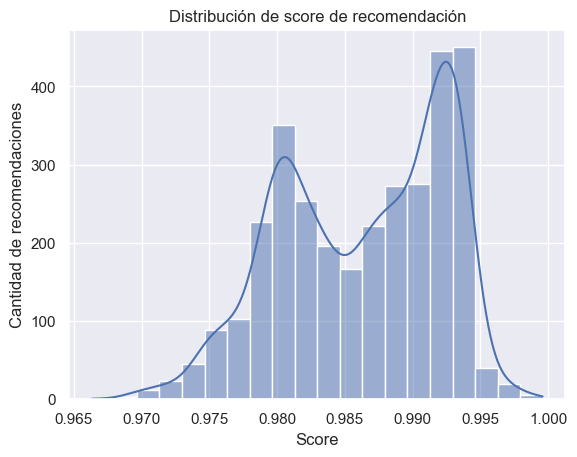

In [70]:
sns.histplot(val['score'], bins=20, kde=True)
plt.title("Distribución de score de recomendación")
plt.xlabel("Score")
plt.ylabel("Cantidad de recomendaciones")
plt.show()


##Top productos más recomendados

In [71]:
top_productos = val['producto_recomendado'].value_counts().head(5)
print("Top 5 productos más recomendados:")
print(top_productos)


Top 5 productos más recomendados:
producto_recomendado
producto_28      2816
producto_27       235
producto_277      120
producto_1227      14
producto_648       10
Name: count, dtype: int64
